In [ ]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook, figure, show
from matplotlib.ticker import LogLocator
import numpy as np

START_TIME = 1.0 # in seconds
BW = 100 # in Gbps
PORT_NO_START = 1000
SAVE_FIG = True
FIG_SIZE = (5,4)

In [ ]:
#@title
def read_flow_stats(flow_stats_filename):

  flow_stats = {}
  with open(flow_stats_filename, 'r') as f:
    for line in f:
      flow_stat_log = line.split()

      time = (float(flow_stat_log[0])*1e-9 - START_TIME) * 1e3 # in miliseconds
      sender = flow_stat_log[1]
      cwnd = float(flow_stat_log[4]) * 1e-3 # in KB
      rtt = float(flow_stat_log[5]) * 1e-3 # in usec

      if (rtt != 0):
        rate = cwnd * 8.0 / rtt # in Gbps

        if sender in flow_stats.keys():
          flow_stats[sender]['times'].append(time)
          flow_stats[sender]['rates'].append(rate)
          flow_stats[sender]['cwnds'].append(cwnd)
          flow_stats[sender]['rtts'].append(rtt)
        else:
          flow_stats[sender] = {}
          flow_stats[sender]['times'] = [time]
          flow_stats[sender]['rates'] = [rate]
          flow_stats[sender]['cwnds'] = [cwnd]
          flow_stats[sender]['rtts'] = [rtt]

  return flow_stats

In [ ]:
#@title
def get_cum_cwnd(flow_stats):
  last_cwnd_of_senders = {}
  for sender in flow_stats.keys():
    last_cwnd_of_senders[sender] = 0

  cum_cwnds = {
      'times': [0],
      'cwnds': [0]
  }

  log_entries = []
  for sender, sender_logs in flow_stats.items():
    for i in range(len(sender_logs['times'])):
      log_entries.append((sender_logs['times'][i], sender_logs['cwnds'][i], sender))
    log_entries.append((log_entries[-1][0],0,sender))

  log_entries = sorted(log_entries, key=lambda x: x[0])

  for entry in log_entries:
    sender = entry[2]
    cum_cwnd = cum_cwnds['cwnds'][-1] - last_cwnd_of_senders[sender] + entry[1]
    cum_cwnds['cwnds'].append(cum_cwnd)
    cum_cwnds['times'].append(entry[0])
    last_cwnd_of_senders[sender] = entry[1]

  return cum_cwnds

In [ ]:
notes = ['', '_FF']

In [ ]:
#@title
trace_path = 'outputs/bolt-fairness/0_DEFAULT'
stats = {}
for note in notes:
  if (note == ''):
    key = 'default'
  else:
    key = note[1:] # Ignore the _ in front
  stats[key] = read_flow_stats(trace_path + note + '.log')

In [ ]:
note_to_save_fig = 'default'

Flow Rates of Bolt (default)


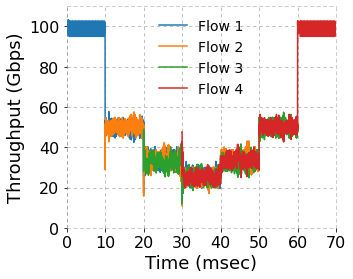

Flow Rates of Bolt (FF)


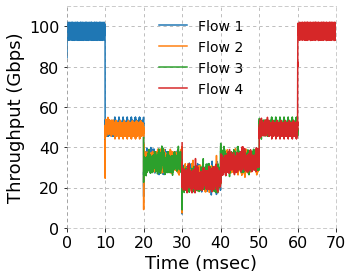

In [ ]:
#@title
fontsize = 16
linestyle = (0,(4,4))
for note, data in stats.items():
  plt.figure(figsize=FIG_SIZE)

  for sender, flow_data in data.items():
    plt.plot(flow_data['times'],flow_data['rates'],
             label="Flow " + str(int(sender.split(':')[1])-PORT_NO_START+1))

  plt.legend(loc = 'upper center', frameon=False, fontsize=fontsize-2) # title = 'Flow ID', 
  plt.grid(linestyle =linestyle)
  print('Flow Rates of Bolt (' + note + ')')
  plt.xlabel('Time (msec)', fontsize=fontsize+2)
  plt.ylabel('Throughput (Gbps)', fontsize=fontsize+2)
  plt.xticks(fontsize=fontsize)
  plt.yticks(fontsize=fontsize)
  plt.ylim([0,110])
  plt.xlim([0,70])
  plt.gca().spines["right"].set_linestyle(linestyle)
  plt.gca().spines["right"].set_alpha(0.5)
  plt.gca().spines["right"].set_color('gray')
  plt.gca().spines["left"].set_linestyle(linestyle)
  plt.gca().spines["left"].set_alpha(0.5)
  plt.gca().spines["left"].set_color('gray')
  plt.gca().spines["top"].set_linestyle(linestyle)
  plt.gca().spines["top"].set_alpha(0.5)
  plt.gca().spines["top"].set_color('gray')
  plt.gca().spines["bottom"].set_linestyle(linestyle)
  plt.gca().spines["bottom"].set_alpha(0.5)
  plt.gca().spines["bottom"].set_color('gray')
  plt.tight_layout()
  if (note == note_to_save_fig and SAVE_FIG):
    plt.savefig('/usr/local/google/home/serhatarslan/Documents/Bolt-Figures/fairness.pdf')
  plt.show()

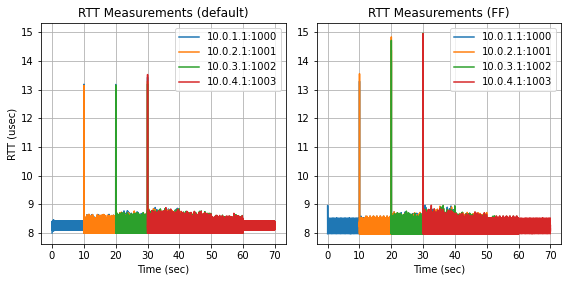

In [ ]:
#@title
plt.figure(figsize=(4*len(notes),4))
xlim = None # [0,0.0005]
ax = []
idx = 0

for note, data in stats.items():
  idx += 1
  if (idx==1):
    ax.append(plt.subplot(1,len(notes),idx))
  else:
    ax.append(plt.subplot(1,len(notes),idx, sharey=ax[0]))

  for sender, flow_data in data.items():
    plt.plot(flow_data['times'],flow_data['rtts'],label=sender)

  if xlim is not None:
    plt.xlim(xlim)

  plt.legend()
  plt.grid()
  plt.title('RTT Measurements (' + note + ')')
  if (idx == 1):
    plt.ylabel('RTT (usec)')
  plt.xlabel('Time (sec)')
  plt.tight_layout()
  
plt.show()

In [ ]:
note_to_analyze = None

In [ ]:
#@title
if (note_to_analyze):
  output_notebook()
  p = figure(plot_width=900, plot_height=400)

  # print(plt.rcParams['axes.prop_cycle'].by_key()['color'])
  colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
  idx = 0
  for sender, flow_data in stats[note_to_analyze].items():
    p.line(flow_data['times'],flow_data['cwnds'], legend_label=sender, line_color=colors[idx])
    idx += 1
  show(p)

In [ ]:
#@title
for note, data in stats.items():
  stats[note]['cum_cwnds'] = get_cum_cwnd(data)

In [ ]:
notes_for_cum_cwnd = ['default','FF']

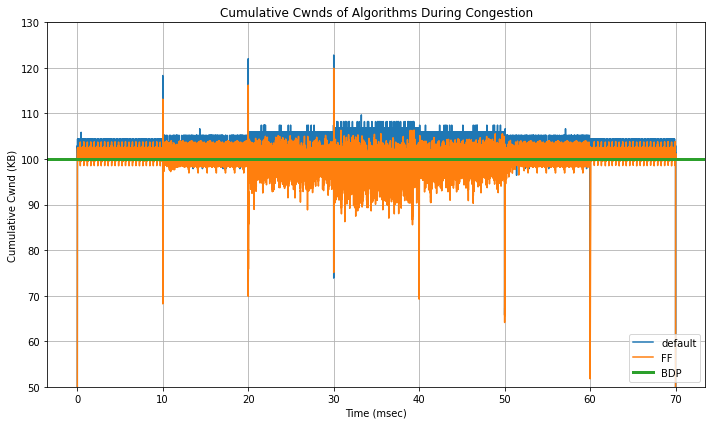

In [ ]:
#@title
plt.figure(figsize=(10,6))
xlim_cum_cwnd = None # [0.00195, 0.00215]

for note, data in stats.items():
  if (note in notes_for_cum_cwnd):
    plt.plot(data['cum_cwnds']['times'], data['cum_cwnds']['cwnds'], label=note)
plt.axhline(y=100 , color='C2', linestyle='-', lw=3, label='BDP')

if xlim_cum_cwnd is not None:
  plt.xlim(xlim_cum_cwnd)
plt.ylim([50,130])

plt.title('Cumulative Cwnds of Algorithms During Congestion')
plt.xlabel('Time (msec)')
plt.ylabel('Cumulative Cwnd (KB)')
plt.grid()
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()